In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 1. Sarsa

In [2]:
class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.ncol = ncol
        self.nrow = nrow
        self.x = 0
        self.y = self.nrow - 1
    
    def step(self, action):
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done
    
    def reset(self):
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x


In [3]:
class Sarsa:
    """ Sarsa Algorithm"""
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action # number of actions
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.epsilon = epsilon # exploration rate
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state][i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1][a1] - self.Q_table[s0][a0]
        self.Q_table[s0][a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 7001.24it/s, episode=50, return=-18.900]


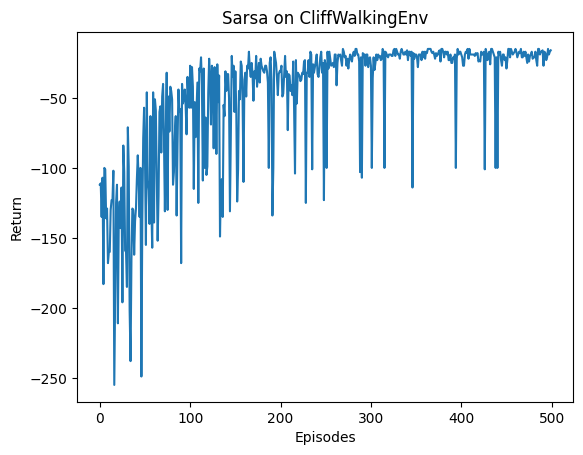

In [4]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (i_episode + 1),
                    'return': '%.3f' % (np.mean(return_list[-10:]))
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Sarsa on {}'.format('CliffWalkingEnv'))
plt.show()

In [6]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()

action_meaning = ['^', 'v', '<', '>']
print('The convergence policy of Sarsa is:')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

The convergence policy of Sarsa is:
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


# 2. N-step Sarsa

In [8]:
class nstep_Sarsa:
    """ n-step Sarsa Algorithm"""
    def __init__(self, n, ncol, crow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n
        self.state_list = []
        self.action_list = []
        self.reward_list = []
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state][i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n:
            G = self.Q_table[s1, a1]
            for i in reversed(range(self.n)):
                G = self.reward_list[i] + self.gamma * G
                if done and i > 0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            s = self.state_list.pop(0)
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        if done:
            self.state_list = []
            self.action_list = []
            self.reward_list = []
            

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3716.58it/s, episode=500, return=-19.100]


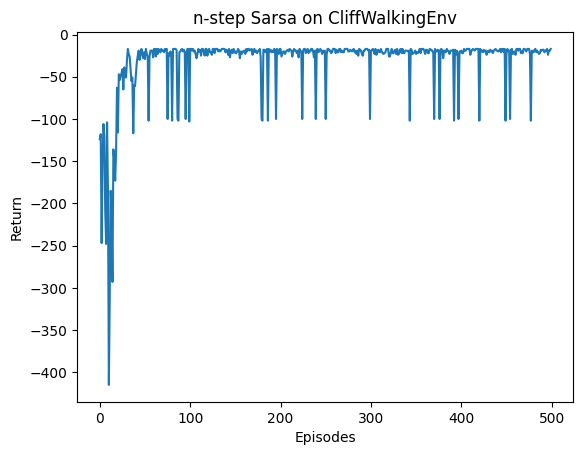

In [9]:
np.random.seed(0)
n_step = 5
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward
                agent.update(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return': '%.3f' % (np.mean(return_list[-10:]))
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('n-step Sarsa on {}'.format('CliffWalkingEnv'))
plt.show()

In [10]:
action_meaning = ['^', 'v', '<', '>']
print('The convergence policy of 5-step Sarsa is:')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

The convergence policy of 5-step Sarsa is:
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


# 3. Q-Learning

In [11]:
class QLearning:
    """ Q-learning Algorithm"""
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state][i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0][a0]
        self.Q_table[s0][a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 10038.06it/s, episode=500, return=-61.700]


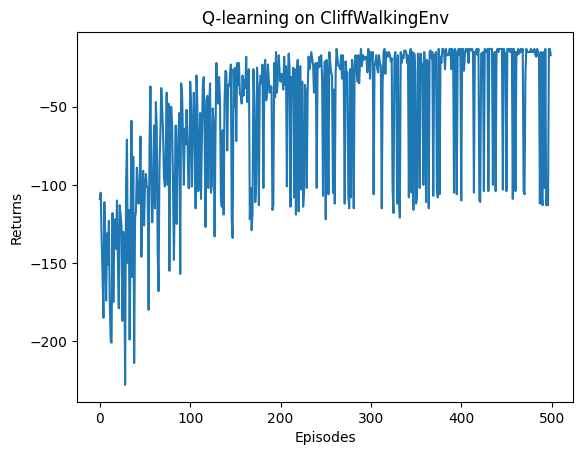

The convergence policy of Q-learning is:
^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [17]:
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return': '%.3f' % (np.mean(return_list[-10:]))
                })
            pbar.update(1)


episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('CliffWalkingEnv'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('The convergence policy of Q-learning is:')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])